<div>
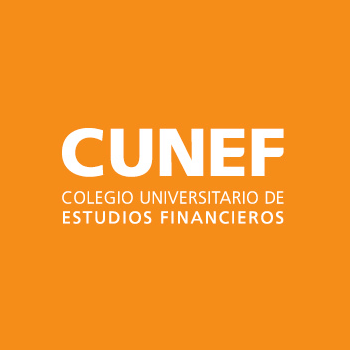
</div>


# **Desempleo en España**

En este notebook se mostrará la serie temporal de la **tasa de paro en España** y observaremos cómo afectó ésta frente al COVID-19. 

La tasa de paro expresa la proporción de parados que hay respecto al total de población activa. Tenemos que tener en cuenta que el desempleado es aquel trabajador que <u> no tiene empleo y que lo busca de forma activa</u>.


Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura del archivo y preparación de datos
    3) Graficación de la serie temporal original
    4) Modelo de suavizado exponencial (ETS)
    5) Modelo autorregresivo integrado de media móvil (ARIMA)
    6) Tipos de outliers
    7) Función de transferencia
    8) Causal Impact y Prophet

## *1) Librerías utilizadas*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *2) Lectura del archivo y preparación de los datos*
Se procede a leer el archivo Excel de la tasa de desempleo español en total y en sectores.

- Fuente: https://www.sepe.es/HomeSepe/que-es-el-sepe/estadisticas/datos-avance/paro.html

In [5]:
df_paro = pd.read_excel("evolparoseries.xls", index_col=0)
df_paro.tail()

,mes,total,agricultura,industria,construccion,servicios,sin_empleo_ant
NaN,202110,3257068,156188,264340,254777,2301618,280145
NaN,202111,3182687,150116,256651,250441,2253090,272389
NaN,202112,3105905,145586,258405,257946,2188281,255687
NaN,202201,3123078,148243,255984,250642,2221908,246301
NaN,202202,3111684,154786,253359,243443,2210670,249426


Para hacer efectivos los plots y sus análisis posteriores, cambiamos el formato de la fecha con la funcionalidad que nos ofrece la librería Pandas y lo indexamos.

In [6]:
df_paro.mes = pd.to_datetime(df_paro.mes, format='%Y%m')

df_paro = df_paro.set_index("mes")
df_paro.tail()

,total,agricultura,industria,construccion,servicios,sin_empleo_ant
mes,,,,,,
2021-10-01,3257068,156188,264340,254777,2301618,280145
2021-11-01,3182687,150116,256651,250441,2253090,272389
2021-12-01,3105905,145586,258405,257946,2188281,255687
2022-01-01,3123078,148243,255984,250642,2221908,246301
2022-02-01,3111684,154786,253359,243443,2210670,249426


## *3) Graficación de la serie temporal*
Para realizar los plots, recurriremos a los que nos ofrece la librería Seaborn:



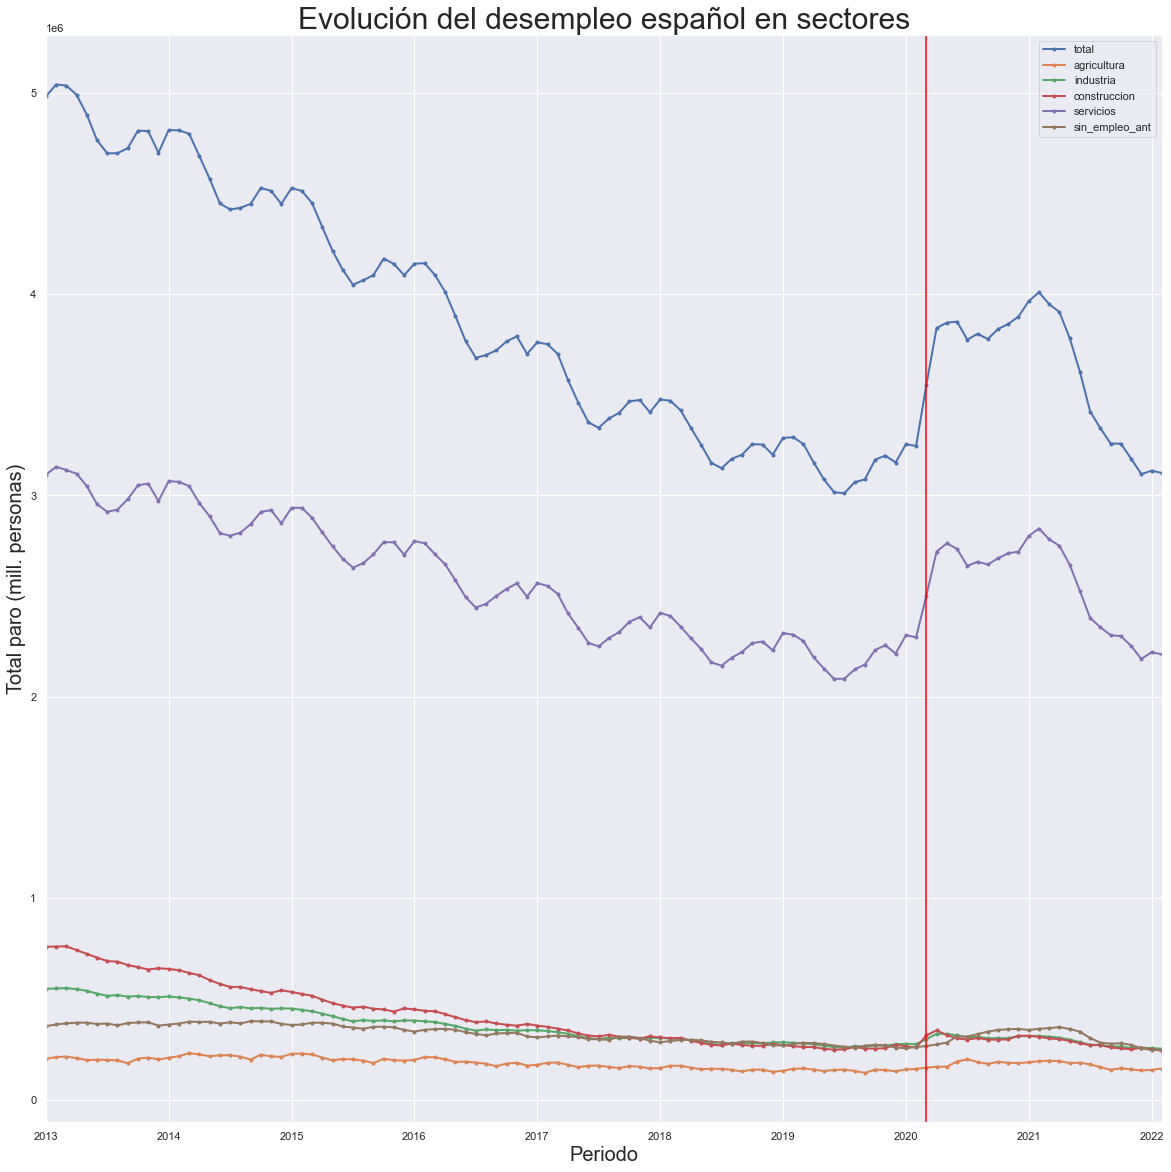

In [14]:
sns.set(rc={'figure.figsize':(20, 20)})
fig = df_paro.plot(marker='.', linewidth= 2)
fig.set_title('Evolución del desempleo español en sectores', fontsize = 30)
fig.set_ylabel('Total paro (mill. personas)', fontsize = 20)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 20);

Lo primero que nos llama la atención del DataFrame es que la serie temporal del desempleo total, que coincide en su mayor parte con el desempleo en el sector servicios (recordemos que España es un país donde el grueso del empleo reside en el sector terciario), sigue una tendencia decreciente hasta llegar a marzo del 2020, momento en el que comienzan las restricciones por COVID-19. Muchos de esos empleados fueron despedidos y pasados por ERTEs debido a este fenómeno anormal, y se ha ido prolongando hasta aproximadamente enero-febrero del 2021, momento en el que vuelve a haber una tendencia decreciente. Se puede apreciar además que antes del COVID-19 había una estacionalidad, encontrándonos mínimos en las épocas de verano.

El desempleo dentro de la industria y construcción, ambas pertenecientes al sector secundario, se observa una estacionalidad con una ligera tendencia también decreciente hasta el inicio de la pandemia, aunque su aumento de desempleo no fue tan marcado como en el sector servicios.

Sin embargo, el desempleo dentro del sector de la agricultura y de los parados que no han trabajado con anterioridad, no se aprecia ningún tipo de estacionalidad ni de tendencia. Para el caso del sector de la agricultura, es debido a que, a pesar de las restricciones por COVID-19, la agricultura es un eslabón importante para que el resto de sectores funcione, mientras que el colectivo sin empleo previo no le afectarían las restricciones porque, sencillamente, nunca tuvieron un empleo antes.

Habiéndonos puesto ya en contexto, necesitaremos solamente los datos de la columna del **total de desempleo** para un análisis más exhaustivo.

In [6]:
df_paro = df_paro.iloc[:,0:1]
df_paro.head()

,total
mes,
2013-01-01,4980778
2013-02-01,5040222
2013-03-01,5035243
2013-04-01,4989193
2013-05-01,4890928


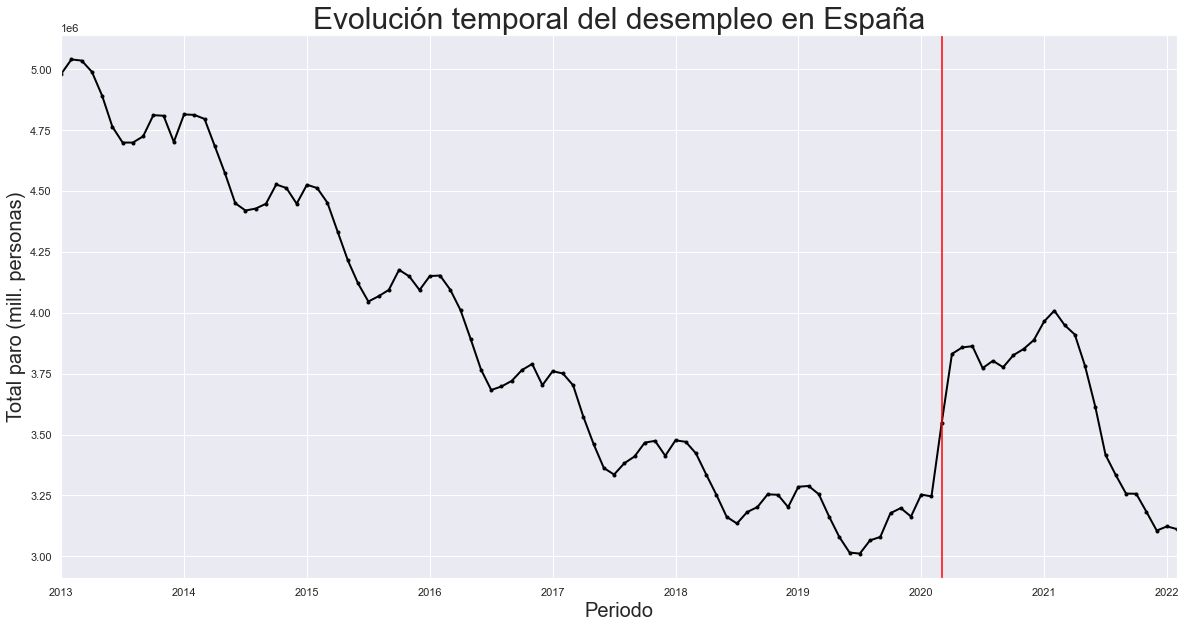

In [22]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_paro.total.plot(marker='.', color = 'black', linewidth= 2)
fig.set_title('Evolución temporal del desempleo en España', fontsize = 30)
fig.set_ylabel('Total paro (mill. personas)', fontsize = 20)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 20);

A continuación, analizaremos la estacionalidad y comprobaremos si la serie temporal es estacionaria mediante:
- Cálculo de la media y de la varianza
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y los residuos

In [15]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [16]:
media = split_and_summarize(df_paro, 'total', 4, np.mean)
varianza = split_and_summarize(df_paro, 'total', 4, np.var)

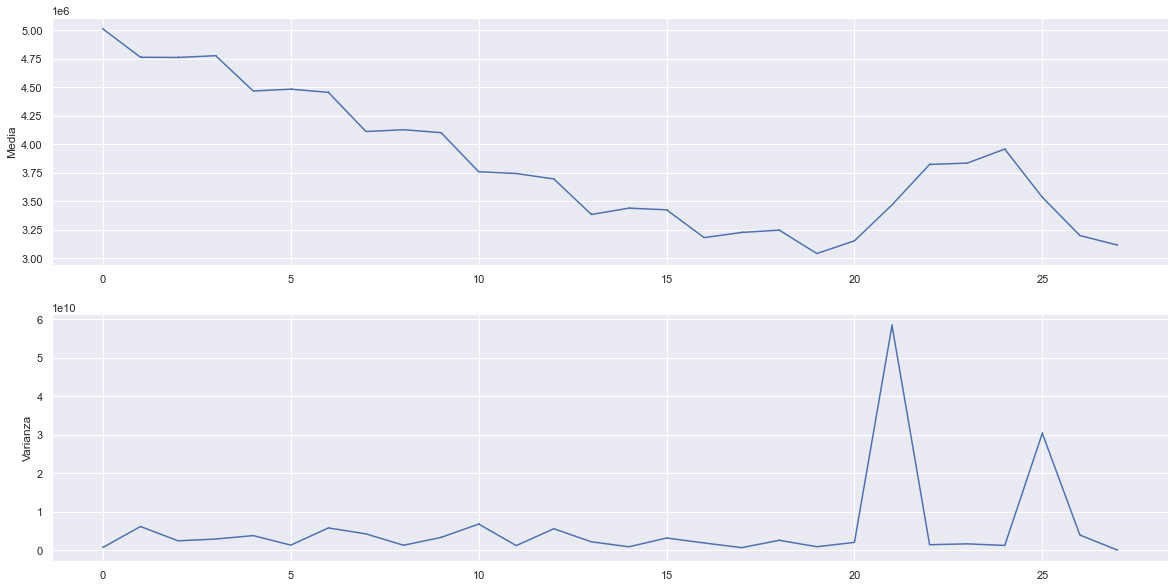

In [24]:
cols = ['media', 'varianza']
df = pd.DataFrame([media, varianza], index=cols)

sns.set(rc={'figure.figsize':(20, 10)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

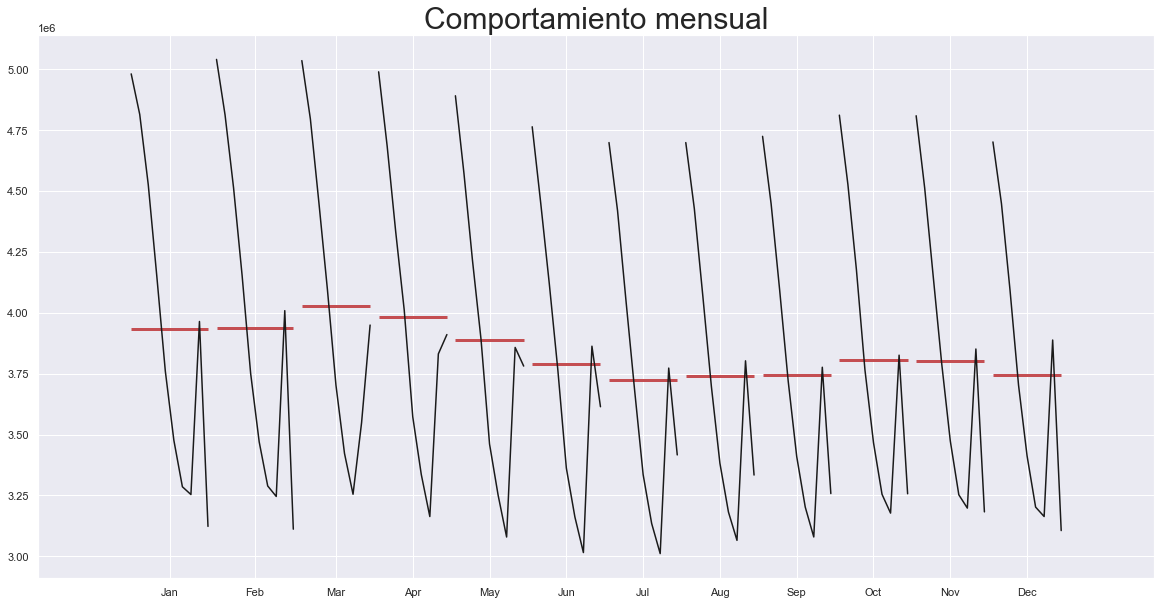

In [25]:
# Componente estacional mensual:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_paro.total, ax = ax)
ax.set_title('Comportamiento mensual', fontsize = 30);

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

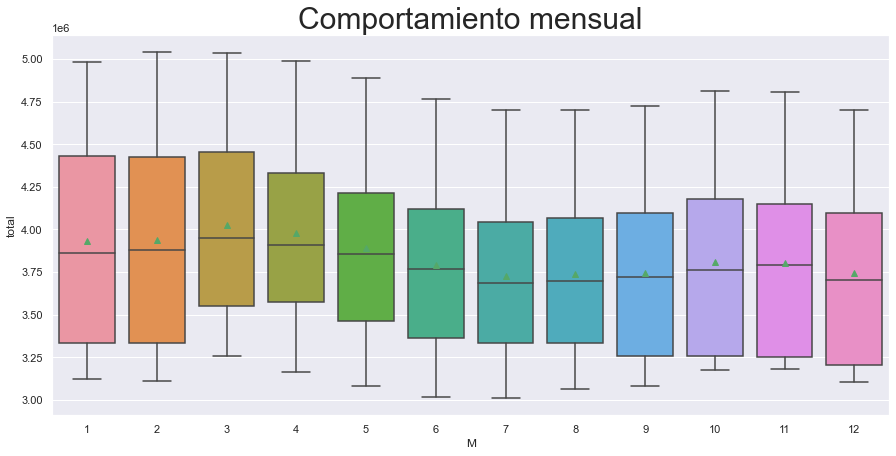

In [12]:
df_paro['M'] = df_paro.index.month
sns.boxplot(data = df_paro, x = 'M', y='total', showmeans=True)
ax = plt.gca()
ax.set_title('Comportamiento mensual', fontsize = 30);

Y, por último, el desglose de la estacionalidad, tendencia y residuos:

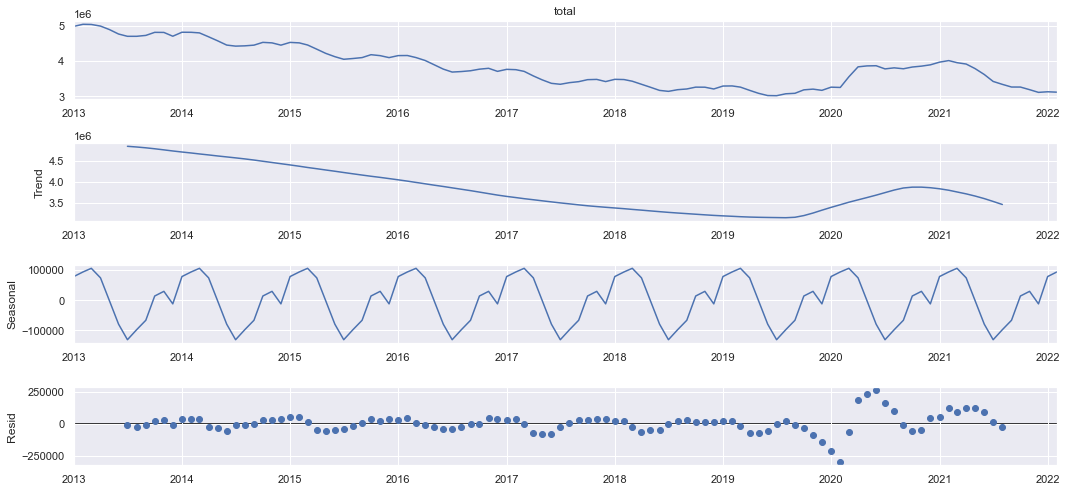

In [14]:
desglose = seasonal_decompose(df_paro.total, 
                                   model='additive', 
                                   period=12);
desglose.plot();

Analizando las gráficas, observamos:

- Que existe una tendencia decreciente de desempleo hasta el momento COVID-19, momento en el que se genera un pico en el comportamiento mes a mes que luego se estabiliza y vuelve a su tendencia decreciente.
- Que el desempleo no es estacionario ni en su media ni en su varianza, fluctúan y se comportan con una tendencia similar: decreciente hasta el momento del Coronavirus. 
- Que los meses que más se crea empleo se hallan en los meses de junio y julio, coincidente con la época de verano, con las vacaciones de muchos empleados y con la creación de nuevos empleos temporales.También se puede apreciar menor desempleo en el mes de diciembre, coincidente con las vacaciones de Navidad.

## *4) Modelo de suavizado exponencial (ETS)*
A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en un año.



102 8


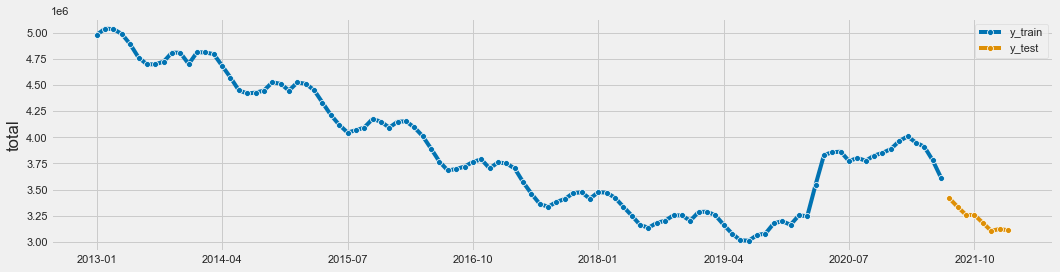

In [57]:
y_train, y_test = temporal_train_test_split(y = df_paro['total'].astype('float64').to_period('M'), 
                                            test_size=8)

plot_series(y_train, y_test, labels=["y_train", "y_test"])

print(y_train.shape[0], y_test.shape[0])

Se realiza el pronóstico (forecasting) del horizonte temporal de 2 años. En sp, que es el número de periodos en un ciclo estacional completo, pondremos 12 para datos mensuales con ciclo anual:

In [24]:
fh = np.arange(1, 7)
paro_autoets = AutoETS(auto=True, 
                       sp=12, 
                       n_jobs=-1)
paro_autoets.fit(y_train)
print(paro_autoets.summary())

                                 ETS Results                                  
Dep. Variable:                  total   No. Observations:                  104
Model:                      ETS(MAdM)   Log Likelihood               -1276.325
Date:                Sun, 08 May 2022   AIC                           2590.650
Time:                        18:54:22   BIC                           2640.893
Sample:                    01-31-2013   HQIC                          2611.005
                         - 08-31-2021   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.325      3.074      0.002       0.362       1.637
smoothing_trend         0.8368      0.637      1.313      0.189      -0.412       2.086
smoothing_season

In [25]:
paro_pred = paro_autoets.predict(fh)

print(paro_pred)

2021-09    3.262627e+06
2021-10    3.254672e+06
2021-11    3.207088e+06
2021-12    3.124695e+06
2022-01    3.158417e+06
2022-02    3.136305e+06
Freq: M, dtype: float64


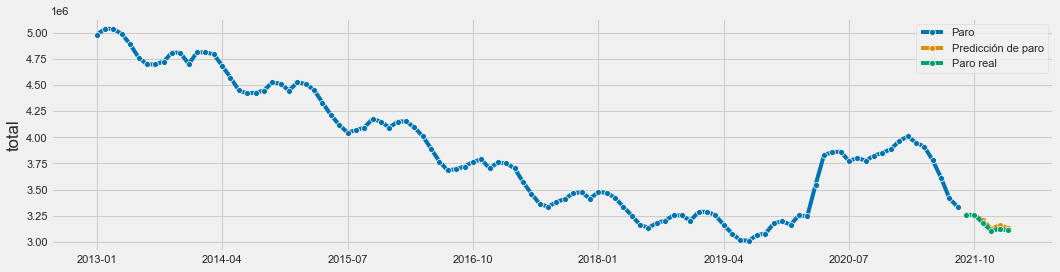

In [26]:
plot_series(y_train, paro_pred, y_test, labels=["Paro", "Predicción de paro", "Paro real"]);

Se hace un zoom al gráfico:

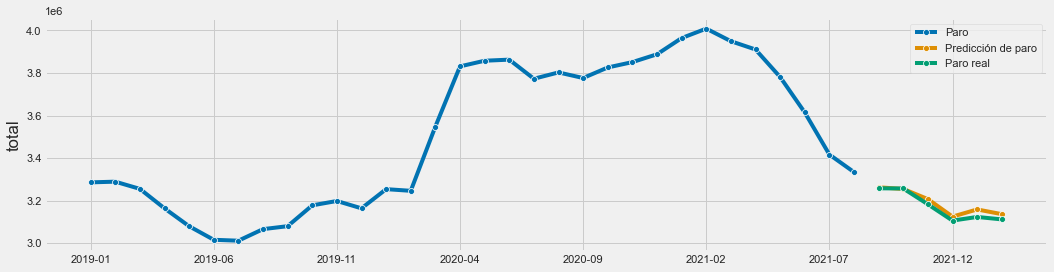

In [27]:
plot_series(y_train["2019":], paro_pred,y_test, labels=["Paro", "Predicción de paro", "Paro real"]);

La predicción por ETS está por encima de la línea de los datos reales, por lo que se concluye que el paro habría empeorado por debajo de dicha predicción. 

#### *Comprobación de la precisión de las predicciones (errores):*

MAPE

In [28]:
mape = mean_absolute_percentage_error(y_test, paro_pred)

In [29]:
mape

0.005836300639347041

MSE

In [32]:
mse = MeanSquaredError()
mse(y_test, paro_pred)

472089562.91280144

RMSE

In [21]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, paro_pred)

17825.457992040196

Ahora se realiza el pronóstico (forecasting) del horizonte temporal de 2 años, o sea, para el 2024:

In [33]:
fh2 = np.arange(1, 25)

paro_autoets_pred = AutoETS(auto=True, sp=12, n_jobs=-1)

y = df_paro['total'].astype('float64').to_period('M')

paro_autoets_pred.fit(y)

print(paro_autoets_pred.summary())

                                 ETS Results                                  
Dep. Variable:                  total   No. Observations:                  110
Model:                      ETS(MAdM)   Log Likelihood               -1346.334
Date:                Sun, 08 May 2022   AIC                           2730.668
Time:                        18:58:20   BIC                           2781.977
Sample:                    01-31-2013   HQIC                          2751.479
                         - 02-28-2022   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.257      3.891      0.000       0.496       1.504
smoothing_trend         0.8246      0.499      1.653      0.098      -0.153       1.803
smoothing_season

#### Predicción de las ventas los 6 futuros trimestres por modelo ETS:

In [34]:
paro_autoets_pred.predict(fh2)

2022-03    3.105342e+06
2022-04    3.066556e+06
2022-05    2.997421e+06
2022-06    2.926315e+06
2022-07    2.882221e+06
2022-08    2.903672e+06
2022-09    2.916494e+06
2022-10    2.973366e+06
2022-11    2.979008e+06
2022-12    2.944883e+06
2023-01    3.009661e+06
2023-02    3.017998e+06
2023-03    3.030060e+06
2023-04    3.006771e+06
2023-05    2.950475e+06
2023-06    2.889525e+06
2023-07    2.853154e+06
2023-08    2.880195e+06
2023-09    2.897596e+06
2023-10    2.957932e+06
2023-11    2.966623e+06
2023-12    2.935080e+06
2024-01    3.001640e+06
2024-02    3.011560e+06
Freq: M, dtype: float64

La representación gráfica de las predicciones a futuro del desempleo en España hasta febrero del 2024:

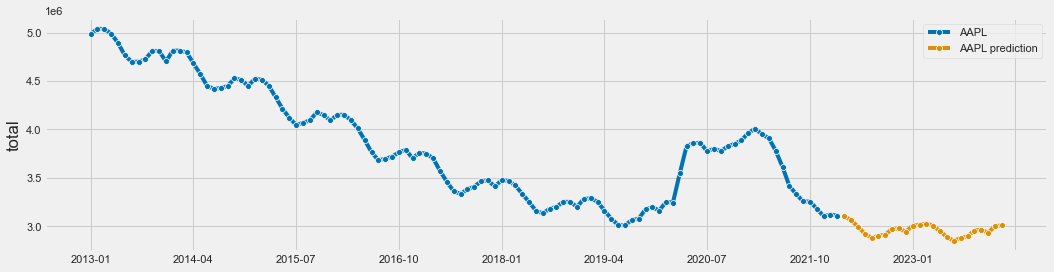

In [36]:
plot_series(y, paro_autoets_pred.predict(fh2), labels=["AAPL", "AAPL prediction"]);

#### Estimación del modelo de forma manual:

In [39]:
forecaster = ExponentialSmoothing(trend='additive', seasonal='multiplicative', sp=12)
forecaster.fit(y)

ExponentialSmoothing(seasonal='multiplicative', sp=12, trend='additive')

In [40]:
y_pred = forecaster.predict(fh2)
y_pred

2022-03    3.061998e+06
2022-04    2.964744e+06
2022-05    2.863769e+06
2022-06    2.769488e+06
2022-07    2.726436e+06
2022-08    2.717900e+06
2022-09    2.713816e+06
2022-10    2.743141e+06
2022-11    2.723137e+06
2022-12    2.656458e+06
2023-01    2.684481e+06
2023-02    2.661746e+06
2023-03    2.613975e+06
2023-04    2.525597e+06
2023-05    2.434277e+06
2023-06    2.348879e+06
2023-07    2.307058e+06
2023-08    2.294407e+06
2023-09    2.285396e+06
2023-10    2.304318e+06
2023-11    2.281629e+06
2023-12    2.219862e+06
2024-01    2.237152e+06
2024-02    2.211960e+06
Freq: M, dtype: float64

In [41]:
print(forecaster._fitted_forecaster.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    total   No. Observations:                  110
Model:             ExponentialSmoothing   SSE                   310119989186.838
Optimized:                         True   AIC                           2425.572
Trend:                         Additive   BIC                           2468.780
Seasonal:                Multiplicative   AICC                          2433.088
Seasonal Periods:                    12   Date:                 Sun, 08 May 2022
Box-Cox:                          False   Time:                         19:00:43
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9950000                alpha                 True
smoothing_trend          

In [42]:
forecaster.get_fitted_params()

{'initial_level': 4868637.330555554,
 'initial_slope': None,
 'initial_seasons': array([1.02789082, 1.03347944, 1.02900491, 1.00873528, 0.98718721,
        0.96665398, 0.96411699, 0.97275764, 0.98455859, 1.00820788,
        1.01442664, 1.0029806 ]),
 'aic': 2425.571923120079,
 'bic': 2468.779608972758,
 'aicc': 2433.088406636563}

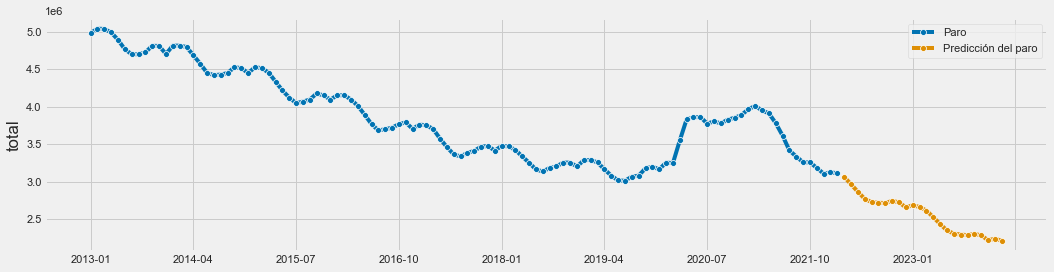

In [43]:
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (sin componente estacional):

In [44]:
forecaster = ExponentialSmoothing(trend='additive',seasonal=None, sp=12)
forecaster.fit(y)

ExponentialSmoothing(sp=12, trend='additive')

In [45]:
y_pred = forecaster.predict(fh2)

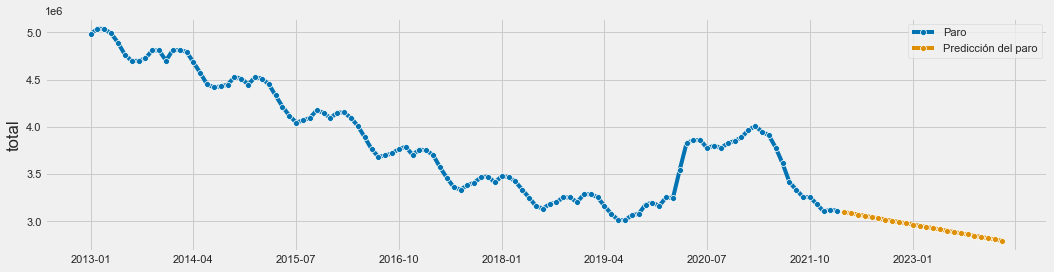

In [46]:
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (sin componente estacional y con tendencia multiplicativa):

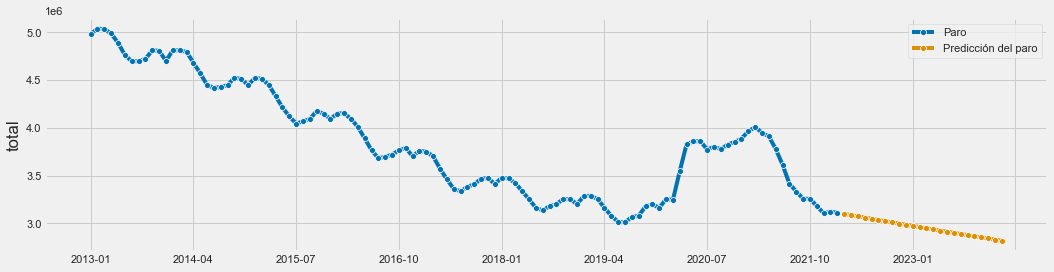

In [47]:
forecaster = ExponentialSmoothing(trend='mul',seasonal=None, sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (sin componente estacional y sin tendencia)

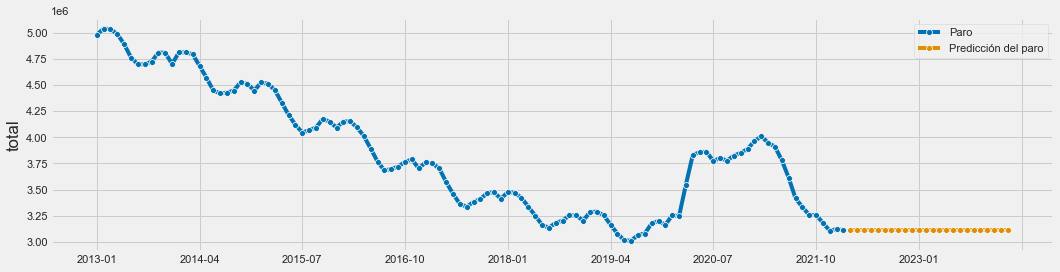

In [48]:
forecaster = ExponentialSmoothing(trend=None,seasonal=None, sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (con componente estacional multiplicativo y sin tendencia):

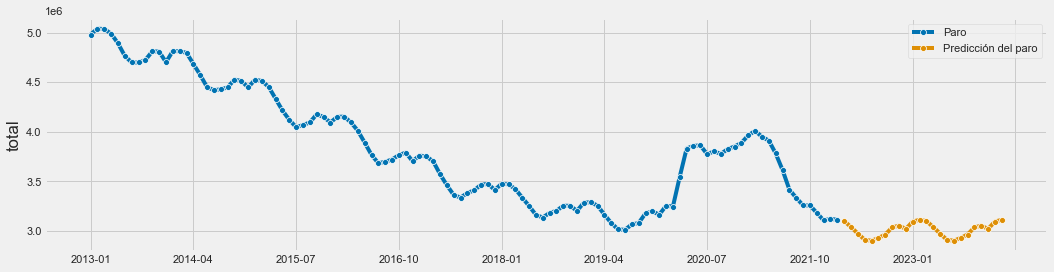

In [49]:
forecaster = ExponentialSmoothing(trend=None,seasonal="mul", sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (con componente estacional aditivo y sin tendencia)

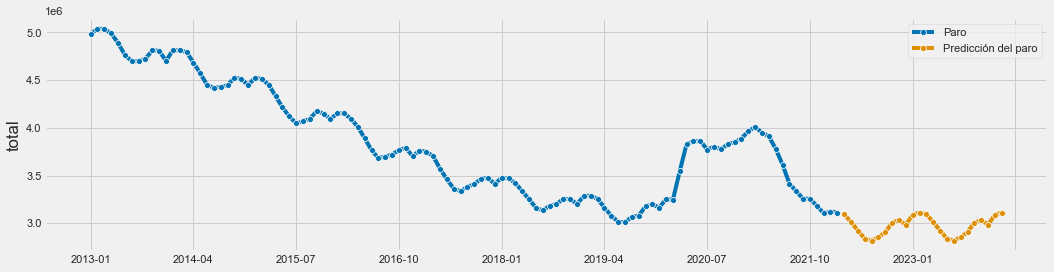

In [53]:
forecaster = ExponentialSmoothing(trend=None,seasonal="add", sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Comparación del modelo con componente estacional aditivo y tendencia aditiva (con y sin dumped):

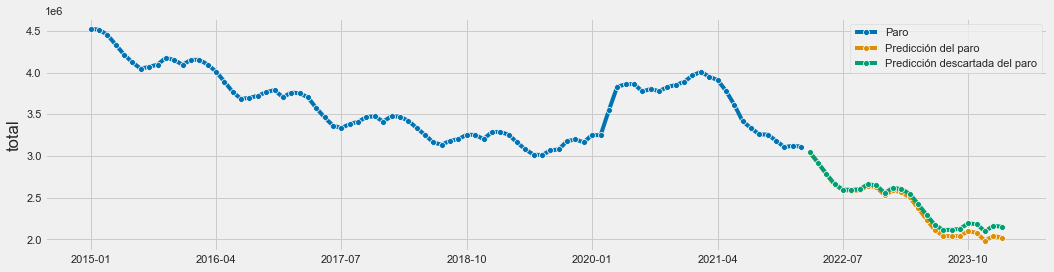

In [52]:
forecaster = ExponentialSmoothing(trend="add",seasonal="add",damped_trend=False, sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)

forecaster = ExponentialSmoothing(trend="add",seasonal="add",damped_trend=True, sp=12)
forecaster.fit(y)
y_pred_dump = forecaster.predict(fh2)
plot_series(y["2015":], y_pred, y_pred_dump,labels=["Paro", "Predicción del paro","Predicción descartada del paro"]);

## *Modelo ARIMA*
Vimos que la serie temporal no era estacionaria ni en su media ni en su varianza, por lo que vamos a realizar los siguientes pasos:
    
    1) comparar la transformación logarítmica de la serie original y la serie en log.
    2) calcular la autocorrelación de la serie logarítmica.
    3) aplicar el modelo ARIMA
    4) (opcional) observar la precisión de los % del error de la media absoluta y del   
    error de la media al cuadrado.

Primero hacemos un resampleo con la librería de Sktime para poder operar con sus datos:

In [54]:
# Resample to Monthly using sktime format
paro_arima = df_paro['total'].astype('float64').to_period('M').sort_index()
paro_arima.tail()

mes
2021-10    3257068.0
2021-11    3182687.0
2021-12    3105905.0
2022-01    3123078.0
2022-02    3111684.0
Freq: M, Name: total, dtype: float64

A continuación, se realiza la transformacion logarítmica de la serie original

In [58]:
transformer = LogTransformer()
log_paro = transformer.fit_transform(paro_arima)
log_paro

mes
2013-01    15.421097
2013-02    15.432961
2013-03    15.431972
2013-04    15.422785
2013-05    15.402893
             ...    
2021-10    14.996338
2021-11    14.973236
2021-12    14.948816
2022-01    14.954330
2022-02    14.950675
Freq: M, Length: 110, dtype: float64

Se comparan la **serie original** y la **serie transformada logarítmicamente** haciendo un ploteo con Sktime:

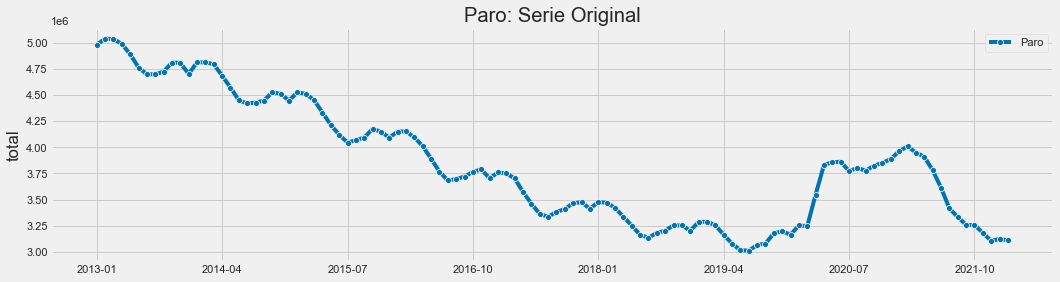

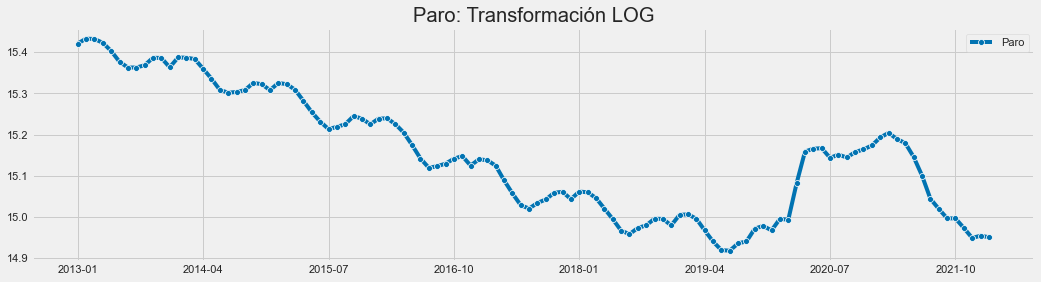

In [59]:
fig, ax =plot_series(paro_arima, labels=["Paro"])
ax.set_title('Paro: Serie Original');

fig, ax =plot_series(log_paro, labels=["Paro"])
ax.set_title('Paro: Transformación LOG');

Ahora pasamos al siguiente paso, que es realizar un **cálculo de la autocorrelación de la serie en logaritmos**:

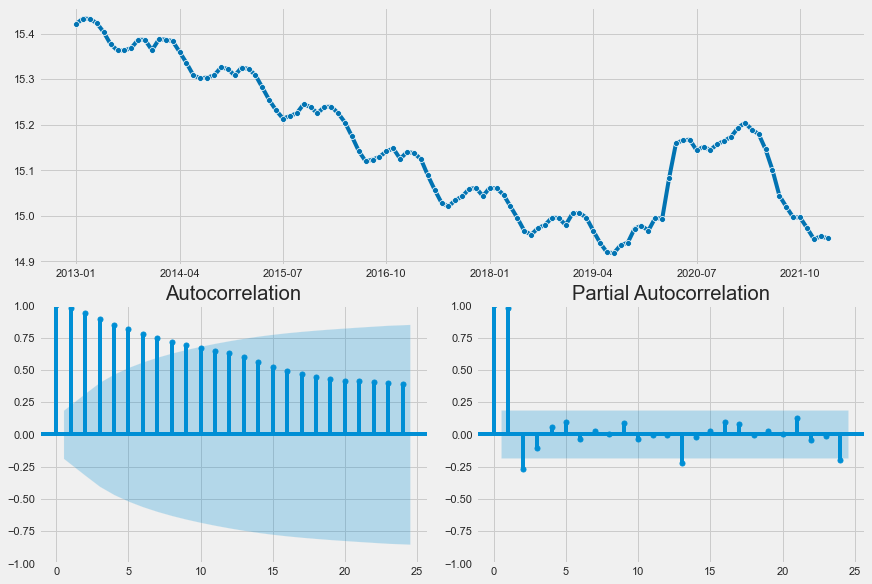

In [60]:
plot_correlations(log_paro);

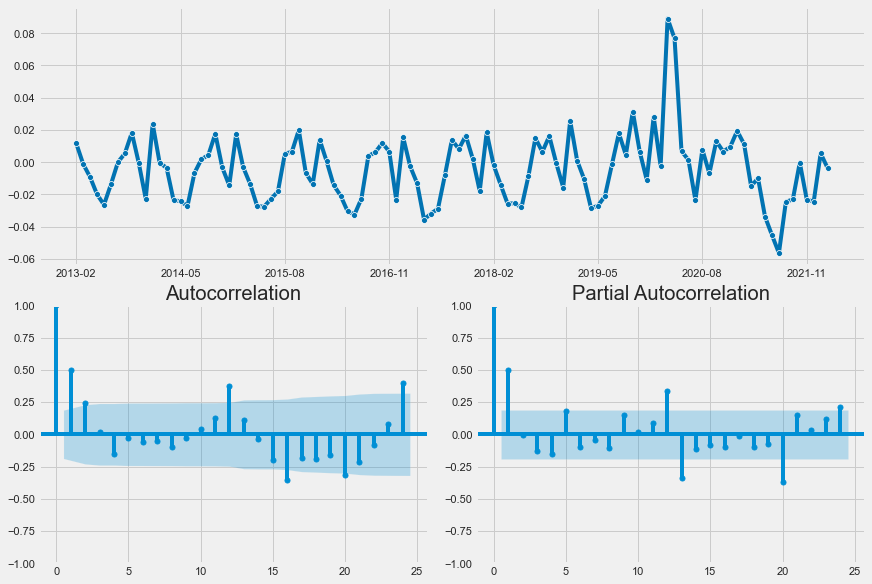

In [61]:
# Función de autocorrelación:
# Parámetros: d=1; D=0; S=4

transf_diff=Differencer(lags=[1])
plot_correlations(transf_diff.fit_transform(log_paro));

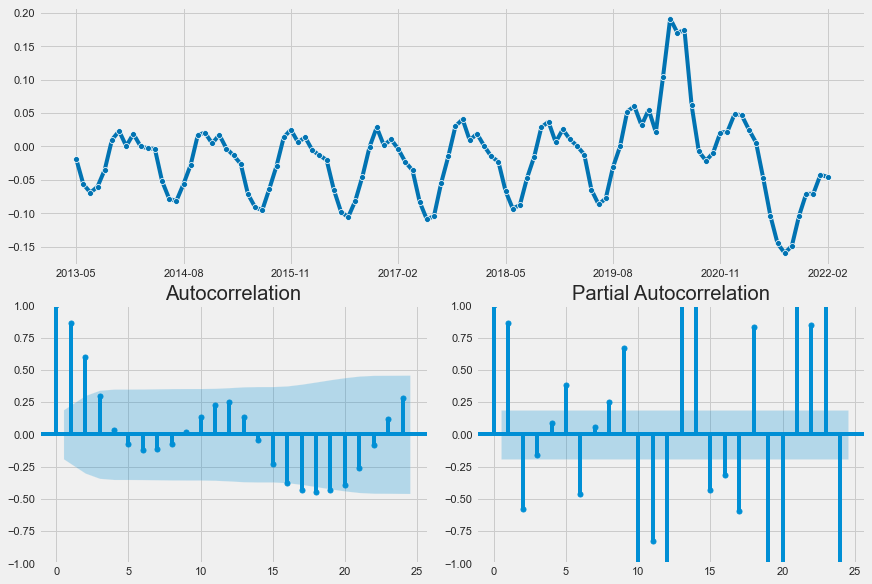

In [62]:
# Función de autocorrelación:
# Parámetros: d=0; D=1; S=4

transf_diff=Differencer(lags=[4])
plot_correlations(transf_diff.fit_transform(log_paro));

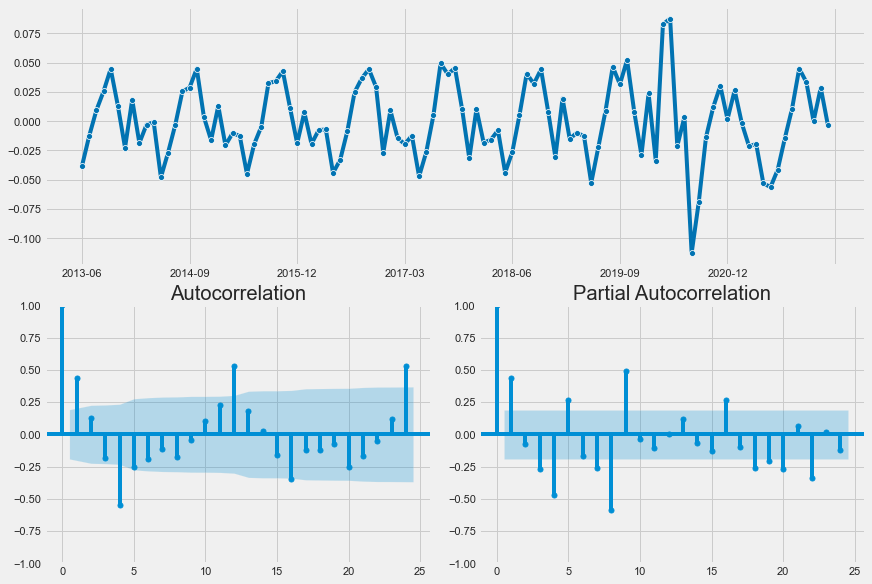

In [63]:
# Función de autocorrelación:
# Parámetros: d=1; D=1; S=4

transf_diff=Differencer(lags=[1,4])
plot_correlations(transf_diff.fit_transform(log_paro));

Como se hizo anteriormente, se separa la muestra en la parte de estimación (Training) y la parte de predicción (Testing):

102 8


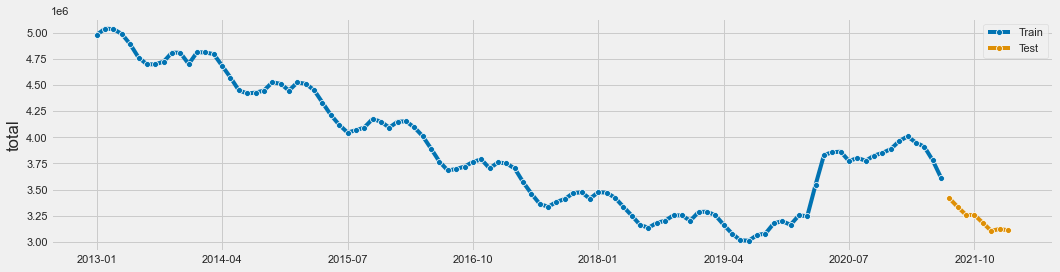

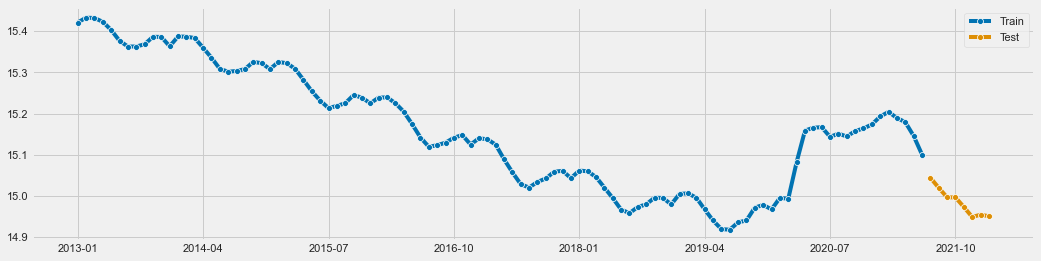

In [72]:
log_y_train, log_y_test = temporal_train_test_split(y=log_paro, test_size=8)

plot_series(y_train, y_test, labels=["Train", "Test"])

plot_series(log_y_train, log_y_test, labels=["Train", "Test"])

print(y_train.shape[0], y_test.shape[0])

In [73]:
# Estimación del horizonte temporal de predicción (forecasting horizon 'fh'):
fh = np.arange(len(y_test)) + 1 
fh

array([1, 2, 3, 4, 5, 6, 7, 8])

In [74]:
# Modelo AutoARIMA:

forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(log_y_train)

AutoARIMA(sp=12, suppress_warnings=True)

In [76]:
print(forecaster.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  102
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 279.290
Date:                              Mon, 09 May 2022   AIC                           -550.580
Time:                                      00:10:30   BIC                           -540.119
Sample:                                           0   HQIC                          -546.345
                                              - 102                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5459      0.044     12.468      0.000       0.460       0.632
ar.S.L12       0.98

Predicción de las últimas ventas por modelo AutoARIMA (en forma logarítmica):

In [77]:
log_y_pred = forecaster.predict(fh)

log_y_pred

2021-07    15.074692
2021-08    15.074662
2021-09    15.073427
2021-10    15.086877
2021-11    15.087538
2021-12    15.076999
2022-01    15.094931
2022-02    15.096394
Freq: M, dtype: float64

Predicción de las últimas ventas por modelo AutoARIMA (en forma de Serie Original):

In [78]:
paro_pred_arima = np.exp(log_y_pred)

paro_pred_arima

2021-07    3.522537e+06
2021-08    3.522432e+06
2021-09    3.518082e+06
2021-10    3.565722e+06
2021-11    3.568081e+06
2021-12    3.530674e+06
2022-01    3.594555e+06
2022-02    3.599817e+06
Freq: M, dtype: float64

**Comprobación de la precisión de las predicciones**

Realización de las funciones SKtime de precisión de la predicción

MAPE (Serie logarítmica)

In [79]:
mean_absolute_percentage_error(log_y_test, log_y_pred)

0.0065021313458801635

MAPE (Serie original)

In [80]:
mape2 = mean_absolute_percentage_error(y_test, np.exp(log_y_pred))

In [81]:
mape2

0.09760928658917321

RMSE (Serie logarítmica)

In [82]:
rmse = MeanSquaredError(square_root=True)

rmse(log_y_test, log_y_pred)

0.10521629874060139

RMSE (Serie original)

In [83]:
rmse = MeanSquaredError(square_root=True)

rmse(y_test, np.exp(log_y_pred))

353432.77331762423

Representación gráfica de las ventas pasadas y de sus respectivas predicciones:

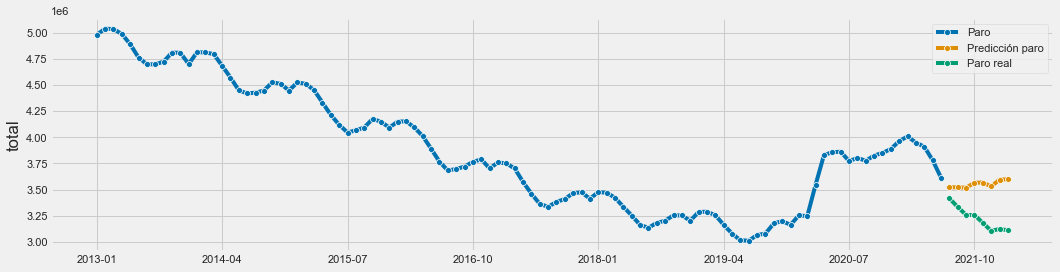

In [84]:

plot_series(y_train, paro_pred_arima, y_test, labels=["Paro", "Predicción paro", "Paro real"]);

Al contrario de lo que ocurría en el modelo ETS, este modelo predice por encima de lo que dicen los datos reales del desempleo en España, aunque ARIMA ha sido mucho menos preciso.